## Imports and helper functions

In [21]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, roc_auc_score, f1_score

N_DATA = 200

In [22]:
# helper_funcs 
def calculate_agreement(model_labels, pos_neg=None, maj_vote=None):
    if pos_neg == None:
        agreement = [int(i == j) for i, j in zip(model_labels, maj_vote)]
        return agreement, np.mean(agreement), len(agreement)
    elif pos_neg == 1:
        agreement = [int(i == j) for i, j in zip(model_labels, maj_vote) if j == 1]
        return agreement, np.mean(agreement), len(agreement)
    elif pos_neg == 0:
        agreement = [int(i == j) for i, j in zip(model_labels, maj_vote) if j == 0]
        print(len(agreement))
        return agreement, np.mean(agreement), len(agreement)
    
def bootstrap_se(data, n_bootstrap=1000):
    means = []
    n = len(data)
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        means.append(np.mean(sample))
    return np.std(means)

def compute_roc_auc(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)
    return fpr, tpr, roc_auc

#### Load labels from human, GPT4, and Llama3.1-8B (prompting), 8B-behavior, Stargate behavior

In [23]:
# eigs and logprobs
eig_files_dict = {
    'Llama_3_EIG (u4, u17)': 'data/expected_info_gain/v0/eigs_5k-user_4_17.json',
    'Logprob_3_Logprob (u4)': 'data/expected_info_gain/v0/logp_5k-user_4.json',
    'Llama_31_EIG (u4, u17)': 'data/expected_info_gain/eig_200_u4-17.json',
}
eig_thresholds = {
    'Llama_3_EIG (u4, u17)': 0.0165,
    'Logprob_3_Logprob (u4)': 0.3,
    'Llama_31_EIG (u4, u17)': 0.0165,
}
raw_model_dict = {}
for k, path in eig_files_dict.items():
    data = json.load(open(path, 'r'))
    raw_model_dict[k] = [d['question_performances'][d['best_question_idx']] for d in data.values()][:N_DATA]
    

In [24]:
gpt4_labels = np.array(json.load(open("data/labels/gpt4_0_200_answer_first.json", "r"))["label"])
llama_3_labels = np.array(json.load(open("data/labels/llama_3_0_200_answer_first.json", "r")))
llama_3_inference_labels = np.array(json.load(open("results/v0/instruct_8b_1_user_questions.json", "r")))
llama_31_labels = np.array(json.load(open("data/labels/8b_10k_questions.json", "r")))[:N_DATA]
llama_31_inference_labels = np.array(json.load(open("data/labels/8b_inference_behavior_questions.json", "r")))
# human labels
maj_vote = np.array(json.load(open("data/labels/exp_when_9_pp_maj_votes_0_200.json", "r")))
mean_vote = np.array(json.load(open("data/labels/exp_when_9_pp_mean_votes_0_200.json", "r")))

model_labels = {    
    "gpt4": gpt4_labels,
    "llama3.1": llama_31_labels,    
    "llama3.1_inference": llama_31_inference_labels,
    "llama3_labels": llama_3_labels,
    "llama3_inference_labels": llama_3_inference_labels,
}

In [25]:
for k, v in raw_model_dict.items():
    model_labels[k] = np.array([int(i > eig_thresholds[k]) for i in v])

for k, v in model_labels.items():
    print(f"{k} labels: positive {np.sum(v)}, negative {len(v) - np.sum(v)}")
print(f"Majority vote labels: {len(maj_vote)}, pos {np.sum(maj_vote)}, neg {len(maj_vote) - np.sum(maj_vote)}")
print(f"Mean vote labels: {len(mean_vote)}, pos {np.sum(mean_vote)}, neg {len(mean_vote) - np.sum(mean_vote)}")

gpt4 labels: positive 84, negative 116
llama3.1 labels: positive 108, negative 92
llama3.1_inference labels: positive 8, negative 192
llama3_labels labels: positive 54, negative 146
llama3_inference_labels labels: positive 11, negative 189
Llama_3_EIG (u4, u17) labels: positive 94, negative 106
Logprob_3_Logprob (u4) labels: positive 95, negative 105
Llama_31_EIG (u4, u17) labels: positive 103, negative 97
Majority vote labels: 200, pos 76, neg 124
Mean vote labels: 200, pos 77.33333333333334, neg 122.66666666666666


In [26]:
# compute F1 for each model's direct labels vs. majority vote labels
model_vs_maj_vote_f1_scores = {}
for model, labels in model_labels.items():    
    f1 = f1_score(maj_vote, labels, average="binary")
    model_vs_maj_vote_f1_scores[model] = f1
    print(f"F1 score for {model} vs. majority vote: {f1}")


F1 score for gpt4 vs. majority vote: 0.7125
F1 score for llama3.1 vs. majority vote: 0.717391304347826
F1 score for llama3.1_inference vs. majority vote: 0.19047619047619047
F1 score for llama3_labels vs. majority vote: 0.5230769230769231
F1 score for llama3_inference_labels vs. majority vote: 0.25287356321839083
F1 score for Llama_3_EIG (u4, u17) vs. majority vote: 0.6
F1 score for Logprob_3_Logprob (u4) vs. majority vote: 0.631578947368421
F1 score for Llama_31_EIG (u4, u17) vs. majority vote: 0.5698324022346368


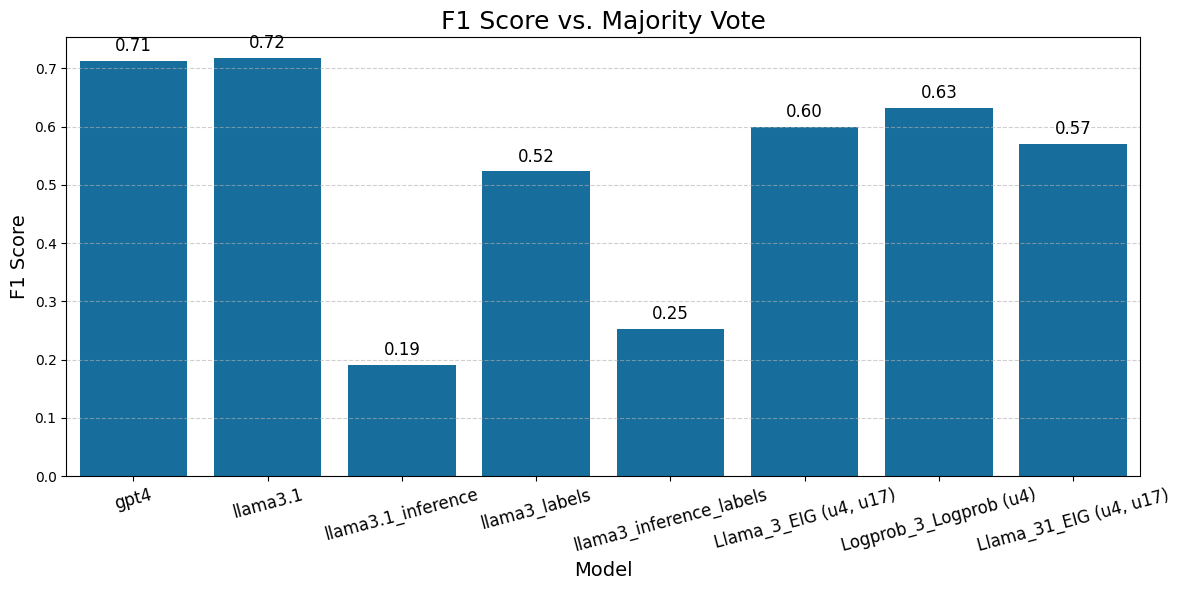

In [27]:
# plot F1 scores, with number on top of each bar
sns.set_palette('colorblind')
plt.figure(figsize=(12, 6))
sns.barplot(x=list(model_vs_maj_vote_f1_scores.keys()), y=list(model_vs_maj_vote_f1_scores.values()))
for i, v in enumerate(model_vs_maj_vote_f1_scores.values()):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=12)
plt.xticks(rotation=15, fontsize=12)
plt.xlabel('Model', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.title('F1 Score vs. Majority Vote', fontsize=18)
plt.tight_layout()

### ROC for different similarities

In [28]:
# custom_palette = sns.color_palette("hsv", 15)
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                  '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
                  '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', 
                  '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5']

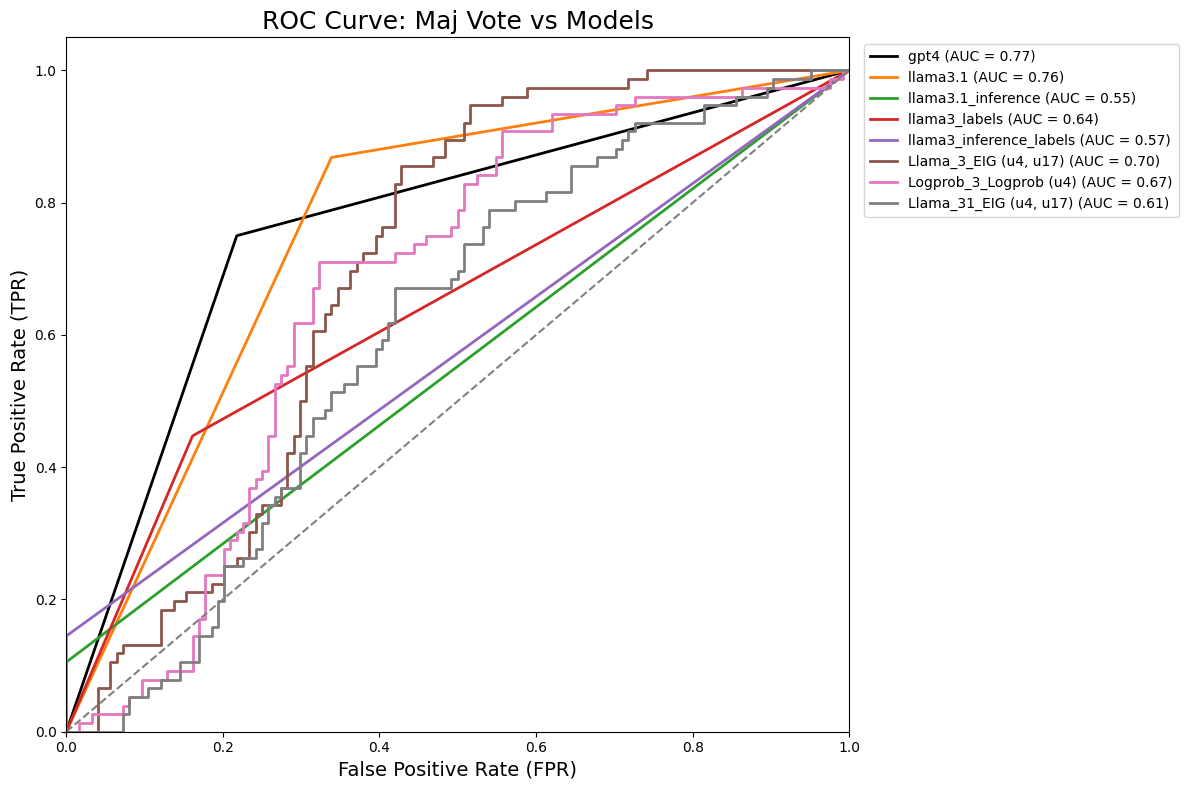

In [29]:
plt.figure(figsize=(12, 8))
sns.set_palette('colorblind')
for i, (model, labels) in enumerate(model_labels.items()):
    if model in raw_model_dict:
        labels = raw_model_dict[model]
    fpr, tpr, roc_auc = compute_roc_auc(maj_vote, labels)
    color = custom_palette[i]
    if model == 'gpt4':
        plt.plot(fpr, tpr, lw=2, color='black', label=f'{model} (AUC = {roc_auc:.2f})')    
    else:
        plt.plot(fpr, tpr, lw=2, color=color, label=f'{model} (AUC = {roc_auc:.2f})')    
    
# baseline: random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curve: Maj Vote vs Models', fontsize=18)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()